# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 11
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Monday, April 23rd, 2018 at 11:59pm

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
import time

import pymc3 as pm
import theano.tensor as T

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## The AM207 Cambridge Nursery

A plant nursery in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to create an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each (the desired effect). 

Out of 197 initial cross-breedings, the nursery obtained the following distribution over the four types of child plants: 
$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$
where $y_i$ represents the number of child plants that are of type $i$.

The nursery then consulted a famed Harvard plant geneticist, who informed them that the probability of obtaining each type of child plant in any single breeding experiment is as follows:
$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}.$$
Unfortunately, the geneticist did not specify the quantity $\theta$.

Clearly, the nursery is interested in understanding how many cross-breeding they must perform, on average, in order to obtain a certain number of child plants with the exotic blue rings. To do this they must be able to compute $\theta$. 

The owners of the nursery, being top students in AM207, decided to model the experiment in hopes of discovering $\theta$ using the results from their 197 initial experiments. 

They chose to model the observed data using a multinomial model and thus calculated the likelihood to be:
$$ p(y  \vert  \theta) \propto (2+\theta)^{y_1} (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$

Being good Bayesians, they also imposed a prior on $\theta$, $\rm{Beta}(a, b)$.

Thus, the posterior is:
$$ p(\theta \vert  Y) = \left( 2+\theta \right)^{y_1} (1-\theta)^{y_2+y_3} \, \theta^{
y_4} \, \theta^{a-1} \, (1-\theta)^{b-1}. $$

If the nursery owners are able to sample from the posterior, they would be able to understand the distribution of $\theta$ and make appropriate estimates.

## Problem 1. Sampling using data augmentation

Realizing that it would be difficult to sample from the posterior directly and after being repeatedly frustrated by attempts of Metropolis-Hastings and Gibbs sampling for this model, the nursery owners decided to augment their model and hopefully obtain a friendlier looking distribution that allows for easy sampling.

They augment the data with a new variable $z$ such that:
$$z + (y_1 - z) = y_1.$$
That is, using $z$, we are breaking $y_1$, the number of type I child plants, into two subtypes. Let the probability of obtaining the two subtype be $1/2$ and $\theta/4$, respectively. Now, we can interpret $y_1$ to be the total number of trials in a binomial trial. Thus, the new likelihood can be written as
$$ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}
$$


Derive the joint posterior $p(\theta, z  \vert  y)$ and sample from it using Gibbs sampling.

Visualize the distribution of theta and, from this distribution, estimate the probability of obtaining a type 4 child plant (with the blue rings) in any cross-breeding experiment.

### Answer to Problem 1

We know $\theta \sim \text{Beta}(a, b)$, and $ p(y, z  \vert  \theta) \propto \binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}$. Thus

$$p(\theta, z \vert y) \propto p(y, z \vert \theta)\, p(\theta) = 
\binom{y_{1}}{z} \left (\frac{1}{2} \right )^{y_1-z} \left(\frac{\theta}{4} \right )^{z}  (1-\theta)^{y_2+y_3}  \, \theta^{y_4}\, \theta^{a-1}(1-\theta)^{b-1}
$$

To obtain conditionals, we keep the relevant variables.

$$p(\theta \vert y, z) \propto \theta^{z+y_4+a-1}(1-\theta)^{y_2+y_3+b-1}$$
i.e.,
$$\theta \vert y, z \sim \text{Beta}(z+y_4+a, y_2+y_3+b).$$
And $$p(z \vert y, \theta) \propto \binom{y_{1}}{z}\left (\frac{2}{\theta+2} \right )^{y_1-z} \left(\frac{\theta}{\theta+2} \right )^{z} $$
i.e.,
$$z \vert y, \theta \sim \text{Binomial}(y_1, \frac{\theta}{\theta+2}).$$
We can implement Gibbs sampling using the above conditionals. And we simply choose a uniform prior for $\theta$ (i.e., $a=b=1$).

In [2]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

def effective_sample_size(data, step=1):
    
    # References:
    # https://code.google.com/p/biopy/source/browse/trunk/biopy/bayesianStats.py?r=67
    # https://am207.github.io/2018spring/wiki/tetchygibbs.html
    
    n = len(data)
    assert n > 1
    maxlags = min(n//3, 1000)
    
    gamma_stat = [0, ] * maxlags
    
    var_stat = 0.0
    
    if type(data) != np.ndarray:
        data = np.array(data)
        
    data_normed = data - data.mean()
    
    for lag in range(maxlags):
        v1 = data_normed[:n-lag]
        v2 = data_normed[lag:]
        v = v1 * v2
        gamma_stat[lag] = sum(v) / len(v)
        
        if lag == 0:
            var_stat = gamma_stat[0]
        elif lag % 2 == 0:
            s = gamma_stat[lag-1] + gamma_stat[lag]
            if s > 0:
                var_stat += 2 * s
            else:
                break
                
    act = step * var_stat / gamma_stat[0]
    ess = step * n / act
    
    return ess
    
def print_ess(data):
    ess1 = effective_sample_size(data[:, 0])
    ess2 = effective_sample_size(data[:, 1])
    print('Effective size for theta:', ess1, ' of', len(data), 'samples; effective rate:', ess1/len(data))
    print('Effective size for z:', ess2, ' of', len(data), 'samples; effective rate:', ess2/len(data))
    
class Gibbs:
    def __init__(self, a=1, b=1, y=np.array([125, 18, 20, 34])):
        self.a = a
        self.b = b
        self.y = y
        
    def run(self, n=20000, x_init=np.array([0.5, 0]), seed=0):
        a = self.a
        b = self.b
        y = self.y
        
        a0 = y[3] + a
        b1 = y[1] + y[2] + b
        
        samples = np.empty((n+1, 2))
        samples[0] = x_init
        
        if seed is not None:
            np.random.seed(seed)
            
        for i in range(1, n+1):
            a1 = samples[i-1, 1] + a0
            samples[i, 0] = np.random.beta(a1, b1)
            
            p = samples[i, 0] / (samples[i, 0] + 2)
            samples[i, 1] = np.random.binomial(y[0], p)
            
        self.n = n
        self.samples = samples[1:]
        return self
    
    def process(self, burnin=0, thin=1):
        self.burnin = burnin
        self.thin = thin
        self.samples2 = self.samples[burnin::thin]
        return self

In [3]:
g0 = Gibbs().run().process(thin=2)

No burnin and thining:
Effective size for theta: 14612.3871292  of 20000 samples; effective rate: 0.73061935646
Effective size for z: 14841.4240569  of 20000 samples; effective rate: 0.742071202847


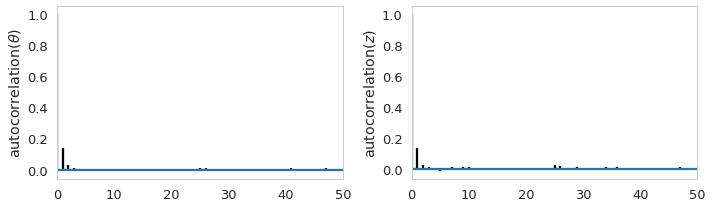

In [4]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g0.samples[:, 0])
plt.ylabel(r'autocorrelation($\theta$)')

plt.subplot(1, 2, 2)
corrplot(g0.samples[:, 1])
plt.ylabel('autocorrelation($z$)')
plt.tight_layout()

print('No burnin and thining:')
print_ess(g0.samples)

burnin = 0, thining = 2:
Effective size for theta: 9592.65625146  of 10000 samples; effective rate: 0.959265625146
Effective size for z: 9406.20749842  of 10000 samples; effective rate: 0.940620749842


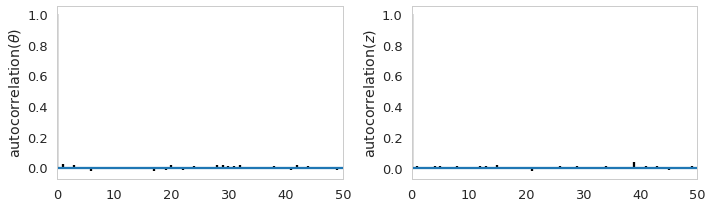

In [5]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
corrplot(g0.samples2[:, 0])
plt.ylabel(r'autocorrelation($\theta$)')

plt.subplot(1, 2, 2)
corrplot(g0.samples2[:, 1])
plt.ylabel('autocorrelation($z$)')
plt.tight_layout()

print('burnin = {}, thining = {}:'.format(g0.burnin, g0.thin))
print_ess(g0.samples2)

As we can see, autocorrelations are negligible after thining at 2.

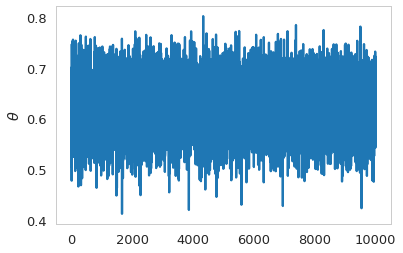

In [6]:
thetas = g0.samples2[:, 0]

plt.plot(thetas);
plt.ylabel(r'$\theta$');

We can visualize the distribution of $\theta$ as follows.

mean(theta) = 0.6229266753714496
std(theta) = 0.05064704358302179


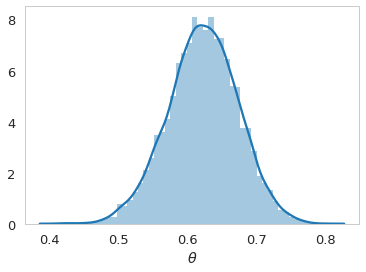

In [7]:
sns.distplot(thetas);
plt.xlabel(r'$\theta$');

print('mean(theta) = {}'.format(np.mean(thetas)))
print('std(theta) = {}'.format(np.std(thetas)))

In [8]:
print('The estimate of the probability of obtaining a type 4 child plant is {:.4f}.'.format(np.mean(thetas/4)))
print('The 2-sigma envelope is [{:.4f}, {:.4f}].'.format(np.mean(thetas/4)-2*np.std(thetas/4), \
                                                         np.mean(thetas/4)+2*np.std(thetas/4)))

The estimate of the probability of obtaining a type 4 child plant is 0.1557.
The 2-sigma envelope is [0.1304, 0.1811].


## Problem 2. Finding the MLE using Expectation Maximization

Treat the augmented model as a latent variable model. 

### Part A. 

Write down an expression (up to unimportant constants - you must decide what unimportant means) for each of the following:

(1) the observed data log likelihood

(2) the complete(full) data log likelihood

**Hint:** You should already have the observed data likelihood and the complete data likelihood from Problem 1, you just need to take their logs for this problem.

(3) the Auxilary function, $Q(\theta, \theta^{(t-1)})$, or the expected complete(full) data log likelihood, defined by
$$Q(\theta, \theta^{(t-1)}) = \mathbb{E}_{Z  \vert  Y=y, \Theta = \theta^{t-1}}[\text{the complete data log likelihood}]$$

In other words $Z  \vert  Y=y, \Theta = \theta^{t-1}$ is $q(z, \theta_{old})$ from lecture at the end of the E-step and $Q$ is the z-posterior expectation (at $\theta_{old}$) of the full data log likelihood, which is the ELBO minus the entropy of $q$ (which being evaluated at $\theta_{old}$ is not dependent on $\theta$ and thus irrelevant for maximization).

### Part B:

We will maximize the likelihood through Expectation Maximization (EM). In order to preform EM, we must iterate through the following steps

- (Expectation) Compute the Auxilary function, $Q(\theta, \theta^{t-1})$ (the expectation of the full data likelihood)
- (Maximization) Compute $\theta^{t} = \text{argmax}_\theta Q(\theta, \theta^{(t-1)})$

Thus, you must compute exact formulae for the following:
1. the Auxilary function, $Q(\theta, \theta^{(t-1)})$, for a given $\theta^{(t-1)}$. That is, compute the expectation of the complete data log likelihood.
2. $\theta^{t}$, by maximizing the Auxilary function $Q(\theta, \theta^{(t-1)})$.

**Hint:** You don't actually need to do any difficult optimization for the M-step. After taking the expectation of the complete data log likelihood in the E-step, match your $Q(\theta, \theta^{(t-1)})$ to the log pdf of a familiar distribution, then use the known formula for the mode of this distribution to optimize $Q(\theta, \theta^{(t-1)})$.

Use these to **estimate the MLE** of $\theta$ using EM (choose your own reasonable criterion for convergence).

### Answer to Problem 2 Part A

Let $n$ be the total number of initial cross-breedings ($n=197$ in this case); let $C_i$ represent unimportant constants.

**(1) the observed data log likelihood**

$$y \vert \theta \sim \text{Multinomial}\left (y; n, \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4}\right )$$

$$\log p(y \vert \theta)=y_1\log (2+\theta)+(y_2+y_3)\log (1-\theta)+y_4\log \theta + C_0$$

**(2) the complete (full) data log likelihood**

$$\log p(y, z \vert \theta) = \log \binom{y_1}{z}+(y_1-z)\log\frac{1}{2}+z\log \frac{\theta}{4}+(y_2+y_3)\log (1-\theta)+y_4\log \theta+C_1$$

**(3) the Auxilary function**

We know from problem 1 that $$z \vert y, \theta \sim \text{Binomial}(y_1, \frac{\theta}{\theta+2})$$. Thus, 
$$\mathbb{E}_{z\vert y,\theta^{t-1}}(z) = \frac{y_1\theta^{t-1}}{\theta^{t-1}+2}.$$

Let $F(z, \theta^{t-1})$ represent terms not involving $\theta$ (including unimportant constants), then

\begin{align}
Q(\theta, \theta^{t-1}) =&\ \mathbb{E}_{z\vert y,\theta^{t-1}}[\log p(y,z\vert \theta)] =\ \mathbb{E}_{z\vert y,\theta^{t-1}}\left [\log \binom{y_1}{z}+(y_1-z)\log\frac{1}{2}+z\log \frac{\theta}{4}+(y_2+y_3)\log (1-\theta)+y_4\log \theta+C_1\right ] \\
=&\ F(z, \theta^{t-1}) + \mathbb{E}_{z\vert y,\theta^{t-1}}[z\log\theta+y_4\log\theta+(y_2+y_3)\log(1-\theta)]\\
=&\ F(z, \theta^{t-1}) + (\mathbb{E}_{z\vert y,\theta^{t-1}}(z)+y_4)\log\theta + (y_2+y_3)\log(1-\theta),
\end{align}
where
$$\mathbb{E}_{z\vert y,\theta^{t-1}}(z) = \frac{y_1\theta^{t-1}}{\theta^{t-1}+2}.$$

### Answer to Problem 2 Part B

At E-step, we need to evaluate
$$\mathbb{E}_{z\vert y,\theta^{t-1}}(z) = \frac{y_1\theta^{t-1}}{\theta^{t-1}+2}.$$

At M-step, we know
$$Q(\theta, \theta^{t-1}) = \ F(z, \theta^{t-1}) + (\mathbb{E}_{z\vert y,\theta^{t-1}}(z)+y_4)\log\theta + (y_2+y_3)\log(1-\theta).$$

Let $\frac{\partial Q(\theta, \theta^{t-1})}{\partial \theta}=0$, we get
$$\theta^t=\frac{y_4+\mathbb{E}_{z\vert y,\theta^{t-1}}(z)}{y_2+y_3+y_4+\mathbb{E}_{z\vert y,\theta^{t-1}}(z)}.$$

We can iterate the process until $\theta$ converges.

In [2]:
class EM:
    def __init__(self, y=np.array([125, 18, 20, 34])):
        self.y = y
        
    def run(self, theta_init=0, max_iter=1000, thres=1e-10):
        y = self.y
        zs = []
        thetas = [theta_init]
        for _ in range(max_iter):
            zs.append(y[0]*thetas[-1]/(thetas[-1]+2))
            thetas.append((y[3]+zs[-1])/(y[1]+y[2]+y[3]+zs[-1]))
            if abs(thetas[-1]-thetas[-2]) < thres:
                break
        self.zs = zs
        self.thetas = thetas
        return self

We can run the algorithm from several different initial $\theta$s to see whether they converge to the same point.

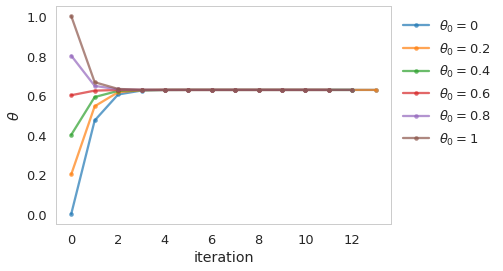

In [3]:
ems = [EM().run(theta_init=t) for t in [0, 0.2, 0.4, 0.6, 0.8, 1]]

for em in ems:
    plt.plot(range(len(em.thetas)), em.thetas, '.-', alpha=0.7, label=r'$\theta_0={}$'.format(em.thetas[0]));
plt.legend(bbox_to_anchor=(1, 1));
plt.xlabel('iteration');
plt.ylabel(r'$\theta$');

As we can see, they all converge to the same point.

In [4]:
print('The estimate of the MLE of theta using EM is {:.4f}.'.format(ems[0].thetas[-1]))

The estimate of the MLE of theta using EM is 0.6268.
